In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

########################################
# 1. 数据加载 & 特征工程
########################################

def load_data_for_xgb(train_path, test_path, seq_length=60):
    """
    演示单步预测：
    - 输入: 过去 seq_length 个时刻的全部特征(含 stock 做OneHot)，预测 t+1 的 MidpointPrice
    - 输出: X_train, y_train, X_test, y_test, scaler
    """

    # 1) 读CSV
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    # 如果没有 MidpointPrice，则自行添加
    if "MidpointPrice" not in train_df.columns:
        train_df["MidpointPrice"] = (train_df["bidPrice"] + train_df["askPrice"]) / 2
    if "MidpointPrice" not in test_df.columns:
        test_df["MidpointPrice"] = (test_df["bidPrice"] + test_df["askPrice"]) / 2

    # 2) 数值列 (你可以根据实际情况调整)
    numeric_cols = [
        "bidVolume",
        "bidPrice",
        "askVolume",
        "askPrice",
        "OrderFlowImbalance",
        "WeightedSpread",
        "MidpointPrice"
    ]

    # 3) 只对 stock 做 OneHot
    #    假设 stock 列只有 {A, B, C, D, E} 这 5 类
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # OneHotEncoder
    # 注意: 新版 scikit-learn 要用 "sparse_output=False" 而不是 "sparse=False"
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # 对 stock 列做 OneHot
    cat_array = combined_df[['stock']].astype(str).values  # shape: (N, 1)
    ohe_feats = ohe.fit_transform(cat_array)               # shape: (N, onehot_dim)

    # 分回 train / test
    n_train = len(train_df)
    ohe_feats_train = ohe_feats[:n_train]
    ohe_feats_test  = ohe_feats[n_train:]

    # 4) 对 numeric_cols 做 MinMaxScaler
    train_numeric = train_df[numeric_cols].values
    test_numeric  = test_df[numeric_cols].values
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled  = scaler.transform(test_numeric)

    # 5) 将编码后的分类特征 & 数值特征拼起来
    #    train_combined shape: (n_train, numeric_size + onehot_dim)
    train_combined = np.hstack([train_numeric_scaled, ohe_feats_train])
    test_combined  = np.hstack([test_numeric_scaled,  ohe_feats_test])

    # 6) 构造“时序窗口”特征 => 单步预测
    #    例如 X[t] = 拼接[t - seq_length, ..., t-1] 的特征
    #         y[t] = 当前时刻 (t) MidpointPrice (的 scaled 值)
    #    注意：我们这里简单地做 “预测 t时刻”，
    #          如果你想预测 (t+1)，则需对应 shift 一下
    def create_supervised_data(data_combined, data_numeric, seq_length):
        """
        data_combined: shape (N, n_features) - scaled numeric + OneHot
        data_numeric:  shape (N, len(numeric_cols)) - scaled numeric(含MidpointPrice)
        seq_length:    int, 历史窗口长度

        返回:
          X_out: (num_samples, seq_length * n_features)
          y_out: (num_samples,)
        """
        X_out, y_out = [], []
        mid_price_idx = 6  # numeric_cols中MidpointPrice的索引(从0开始)
        N = len(data_combined)
        for i in range(seq_length, N):
            # 过去 seq_length 行 => flatten 到一维
            x_i = data_combined[i-seq_length:i].flatten()
            # 目标 => 当前行(i) 的 MidpointPrice
            #   注意：这里是“单步预测”，所以目标就是 data_numeric[i, mid_price_idx]
            y_i = data_numeric[i, mid_price_idx]
            X_out.append(x_i)
            y_out.append(y_i)
        return np.array(X_out), np.array(y_out)

    X_train, y_train = create_supervised_data(train_combined, train_numeric_scaled, seq_length)
    X_test, y_test   = create_supervised_data(test_combined,  test_numeric_scaled,  seq_length)

    return X_train, y_train, X_test, y_test, scaler



In [ ]:

########################################
# 2. 训练 & 测试
########################################

def train_xgboost_regressor(X_train, y_train, X_test, y_test):
    """
    使用 XGBRegressor, 在构造时或fit时指定参数.
    """
    model = xgboost.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='rmse',
        early_stopping_rounds=20
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
    return model

def evaluate_and_visualize(model, X_test, y_test, scaler, seq_length):
    """
    预测并做逆归一化，只针对MidpointPrice.
    """
    y_pred_scaled = model.predict(X_test)  # (N_test,)

    # MidpointPrice在 numeric_cols中的索引=6
    mid_price_idx = 6
    numeric_size = 7  # numeric_cols 有7列
    # 将预测结果放到第 mid_price_idx 列
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    N_test = len(y_pred_scaled)

    dummy = np.zeros((N_test, numeric_size))
    dummy[:, mid_price_idx] = y_pred_scaled[:, 0]
    inv_all = scaler.inverse_transform(dummy)
    y_pred_inv = inv_all[:, mid_price_idx]

    # 还原 y_test
    y_test = y_test.reshape(-1, 1)
    dummy_true = np.zeros((N_test, numeric_size))
    dummy_true[:, mid_price_idx] = y_test[:, 0]
    inv_all_true = scaler.inverse_transform(dummy_true)
    y_true_inv = inv_all_true[:, mid_price_idx]

    # 评估指标
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"XGBoost Test MSE : {mse:.4f}")
    print(f"XGBoost Test RMSE: {rmse:.4f}")
    print(f"XGBoost Test MAE : {mae:.4f}")

    # 画图
    n_plot = min(200, len(y_true_inv))
    plt.figure(figsize=(12,6))
    plt.plot(range(n_plot), y_true_inv[-n_plot:], label='Actual Price')
    plt.plot(range(n_plot), y_pred_inv[-n_plot:], label='Predicted Price')
    plt.title("XGBoost Price Prediction (Last 200 Points)")
    plt.legend()
    plt.show()



[0]	validation_0-rmse:0.51847
[1]	validation_0-rmse:0.49581
[2]	validation_0-rmse:0.47430
[3]	validation_0-rmse:0.45386
[4]	validation_0-rmse:0.43447
[5]	validation_0-rmse:0.41609
[6]	validation_0-rmse:0.39855
[7]	validation_0-rmse:0.38194
[8]	validation_0-rmse:0.36621
[9]	validation_0-rmse:0.35124
[10]	validation_0-rmse:0.33705
[11]	validation_0-rmse:0.32339
[12]	validation_0-rmse:0.31059
[13]	validation_0-rmse:0.29843
[14]	validation_0-rmse:0.28675
[15]	validation_0-rmse:0.27573
[16]	validation_0-rmse:0.26515
[17]	validation_0-rmse:0.25525
[18]	validation_0-rmse:0.24572
[19]	validation_0-rmse:0.23684
[20]	validation_0-rmse:0.22821
[21]	validation_0-rmse:0.22014
[22]	validation_0-rmse:0.21228
[23]	validation_0-rmse:0.20483
[24]	validation_0-rmse:0.19791
[25]	validation_0-rmse:0.19131
[26]	validation_0-rmse:0.18494
[27]	validation_0-rmse:0.17890
[28]	validation_0-rmse:0.17335
[29]	validation_0-rmse:0.16782
[30]	validation_0-rmse:0.16272
[31]	validation_0-rmse:0.15776
[32]	validation_0-

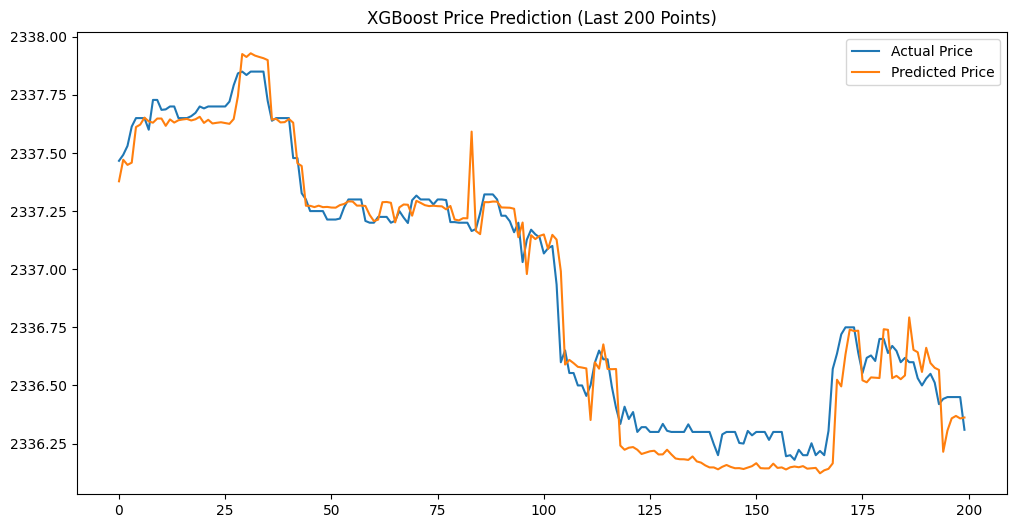

In [ ]:
########################################
# 3. 主流程整合
########################################
if __name__ == "__main__":
    import xgboost

    TRAIN_CSV = "/content/drive/MyDrive/Colab_Notebooks/McHacks/featured_data/D_stock.csv"
    TEST_CSV  = "/content/drive/MyDrive/Colab_Notebooks/McHacks/test_data/D_stock.csv"
    seq_length = 60

    # 1) 数据准备
    X_train, y_train, X_test, y_test, scaler = load_data_for_xgb(
        TRAIN_CSV, TEST_CSV, seq_length=seq_length
    )

    # 2) 训练
    model = train_xgboost_regressor(X_train, y_train, X_test, y_test)

    # 3) (可选) 保存模型
    model.save_model("/content/drive/MyDrive/Colab_Notebooks/McHacks/saved_models/xgb_model_D.json")

    # 4) 测试集评估 & 可视化
    evaluate_and_visualize(model, X_test, y_test, scaler, seq_length)
